# Transformer

In [ ]:
!pip install konlpy
!pip install wandb
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
!pip install transformers==4.4.1
!pip install tokenizers==0.10.1
!pip install -q -U keras-tuner

     |████████████████████████████████| 19.4MB 46.7MB/s 
     |████████████████████████████████| 450kB 45.4MB/s 
     |████████████████████████████████| 92kB 11.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 1.8MB 7.4MB/s 
     |████████████████████████████████| 174kB 51.6MB/s 
     |████████████████████████████████| 102kB 9.1MB/s 
     |████████████████████████████████| 133kB 45.3MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=ab32cf7a8329390c4ddc1199ccf5e3de7bdc1b4cdb55afb1a926429e46014fb7
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=9a0c0bfee8e67257ce25339d5f4239122ed0f844051881724be74

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd content/

/content


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import tensorflow_datasets as tfds
import tensorflow as tf
from konlpy.tag import Komoran
import os
import collections
import pandas as pd
import sys
import nltk
import wandb
from wandb.keras import WandbCallback
import datetime
import keras
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from konlpy.tag import Mecab 
import nltk.translate.bleu_score as bleu
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizerFast
from sklearn.model_selection import KFold
import IPython
import kerastuner as kt
nltk.download('punkt')
komoran = Komoran()
mecab = Mecab().morphs
data_directory = "/content/drive/My Drive/comic_trans_project/data"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# data_processing

class Kor2EngData:
    def __init__(self, data_dir):
        self.files = os.listdir(data_dir)
        self.files = [os.path.join(data_dir, f) for f in self.files]
        self.eng = []
        self.kor = []
        self.datas = []
        
    def data_processing(self):
        self.make_data_to_list()
        self.split_eng_kor()
        
        return self.eng, self.kor
        
    def make_data_to_list(self):
        for file in self.files:
            try:
                with open(file, 'r', encoding='cp949') as f:
                    all_data = f.readlines()
                    
                    for data in all_data:
                        data = data.replace('\n', '')
                        data = data.replace('#', '')
                                       
                        if len(data) != 0:
                            self.datas.append(data)
            except:
                pass
        
    def split_eng_kor(self):        
        for i in range(len(self.datas) - 3):
            if self.datas[i][0] == '[':
                if self.datas[i + 3][0] == '[': 
                    self.eng.append(clean_text(self.datas[i + 1]))
                    self.kor.append(clean_text(self.datas[i + 2]))
                    

    def make_dictionary(self, data, Korean=False):
        words = []
        for sentence in data:
            if not Korean:
                tokens = nltk.word_tokenize(sentence)
                            
            else:
                tokens = komoran.morphs(sentence)
              # tokens = mecab(sentence)
            for word in tokens:
                if has_number(word):
                    tokens.remove(word)
                        
            words.extend(tokens)

        words = collections.Counter(words)

        dictionary = {}
        dictionary['<PAD>'] = 0
        dictionary['<UNK>'] = 1
        dictionary['<EOS>'] = 2
        dictionary['<S>'] = 3
        idx = 4
        for word in words.most_common():
            if len(word[0]) > 0:
                dictionary[word[0]] = idx
                idx += 1
            
            if idx >= 20000: break;

        return dictionary
    
def clean_text(text):
    return re.sub('[\{\}\[\]\/,;:|\)*~`^\-_+<>@\#$%&\\\=\(\"“”◀▶【©】☎]', '', text.lower())

def has_number(word):
    return any(char.isdigit() for char in word)

In [ ]:
MAX_LENGTH = 68

kor2eng = Kor2EngData(data_directory)
eng, kor = kor2eng.data_processing()

eng_dict = kor2eng.make_dictionary(eng)
kor_dict = kor2eng.make_dictionary(kor, True)

output_dict = {y:x for x,y in eng_dict.items()}
input_dict = {y:x for x,y in kor_dict.items()}

eng_dict_size = len(eng_dict)
kor_dict_size = len(kor_dict)

eng_df = pd.DataFrame(eng, columns=['English'])
kor_df = pd.DataFrame(kor, columns=['Korean'])
kor2eng = pd.concat([eng_df, kor_df], axis=1)

for i, eng in enumerate(kor2eng['English']):
    if len(eng) > MAX_LENGTH:
        kor2eng.drop(kor2eng.index[i])
for i, kor in enumerate(kor2eng['Korean']):
    if len(kor) > MAX_LENGTH:
        kor2eng.drop(kor2eng.index[i])

print("English Dictionary Size: ", eng_dict_size)
print("Korean Dictionary Size: ", kor_dict_size)


English Dictionary Size:  20000
Korean Dictionary Size:  17557


In [ ]:
train_size = int(len(kor2eng['Korean'])*0.9)
train_size
train = kor2eng[:train_size]
test = kor2eng[train_size:]
test.reset_index(drop=True,inplace=True)
train.shape, test.shape

((54501, 2), (6056, 2))

In [ ]:
# 벡터화

def vectorize_data(data, dictionary, Korean=False):
    max_len = 67
    vec_sentence = []

    for sentence in data:
        temp = []
        
        temp.append(dictionary['<S>'])
        
        if not Korean:
            for word in nltk.word_tokenize(sentence):
                if len(word) > 0:
                    if word in dictionary:
                        temp.append(dictionary[word])
                    else:
                        temp.append(dictionary['<UNK>'])
        else:
            
            for word in komoran.morphs(sentence):
                if len(word) > 0:
                    if word in dictionary:
                        temp.append(dictionary[word])
                    else:
                        temp.append(dictionary['<UNK>'])
            
        temp.append(dictionary['<EOS>'])
        
        if max_len < len(temp):
            max_len = len(temp)

        vec_sentence.append(temp)
        
    return vec_sentence, max_len

def add_padding(vec_data, max_len):
    for sentence in vec_data:
        for i in range(len(sentence), max_len + 1):
            sentence.append(0)
    
    return np.array(vec_data)

kor_vec_train, kor_max_train = vectorize_data(train['Korean'], kor_dict, True)
kor_vec_test, kor_max_test = vectorize_data(test['Korean'], kor_dict, True)
eng_vec_train, eng_max_train = vectorize_data(train['English'], eng_dict)
eng_vec_test, eng_max_test = vectorize_data(test['English'], eng_dict)

x_train = add_padding(kor_vec_train, kor_max_train)
x_test = add_padding(kor_vec_test, kor_max_test)
y_train = add_padding(eng_vec_train, eng_max_train)
y_test = add_padding(eng_vec_test, eng_max_test)

In [ ]:
print('한국어 데이터의 크기(shape) :', x_train.shape)
print('영어 데이터의 크기(shape) :', y_train.shape)

한국어 데이터의 크기(shape) : (54501, 68)
영어 데이터의 크기(shape) : (54501, 68)


In [ ]:
# 0번 샘플을 임의로 출력
print(x_train[0])
print(y_train[0])

[   3  455  252   36   10   12  686   13  189 1504    6   24   45  179
    4   10    7  110   49    8 3265    6    7   21    9 2014  650   22
    4    2    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[   3   37   27  335    6  922   15  761   11   24  143    8 2954    6
   35 7656   19    4    2    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
print(y_train[0])
print(y_train[:1][:, :-1])
print(y_train[:1][:, 1:]) 

[   3   37   27  335    6  922   15  761   11   24  143    8 2954    6
   35 7656   19    4    2    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[[   3   37   27  335    6  922   15  761   11   24  143    8 2954    6
    35 7656   19    4    2    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]
[[  37   27  335    6  922   15  761   11   24  143    8 2954    6   35
  7656   19    4    2    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [ ]:
def make_dataset(x_data, y_data):

  # 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
  # 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
  BATCH_SIZE = 64
  BUFFER_SIZE = 20000

  # 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
  dataset = tf.data.Dataset.from_tensor_slices((
      {
          'inputs': x_train,
          'dec_inputs': y_train[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
      },
      {
          'outputs': y_train[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
      },
  ))

  dataset = dataset.cache()
  dataset = dataset.shuffle(BUFFER_SIZE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return dataset

In [ ]:
train_data = make_dataset(x_train, y_train)
test_data = make_dataset(x_test, y_test)

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_config(self):
    cfg = super().get_config()
    return cfg 
    
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


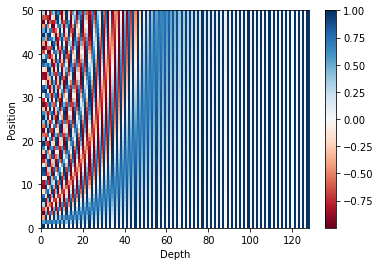

(1, 50, 128)

In [ ]:
# 문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()
(1, 50, 128)

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [ ]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

In [ ]:
# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  def get_config(self):
    cfg = super().get_config()
    return cfg 
    
  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, attention_weights = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs, attention_weights

 

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention,_ = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(kor_dict_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(kor_dict_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(kor_dict_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1, attn_weights_block1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2, attn_weights_block2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)
  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=[outputs],
      name=name)

In [ ]:
def decoder(eng_dict_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(eng_dict_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(eng_dict_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
  
  attention_weights = {}

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs= decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    # attention_weights[f'decoder_layer{i+1}_block1'] = block1
    # attention_weights[f'decoder_layer{i+1}_block2'] = block2

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=[outputs],
      name=name)

In [ ]:
def transformer(kor_dict_size, eng_dict_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(kor_dict_size=kor_dict_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs= decoder(eng_dict_size=eng_dict_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=eng_dict_size, name="outputs")(dec_outputs)
  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 17557, 128)
(1, 20000, 128)


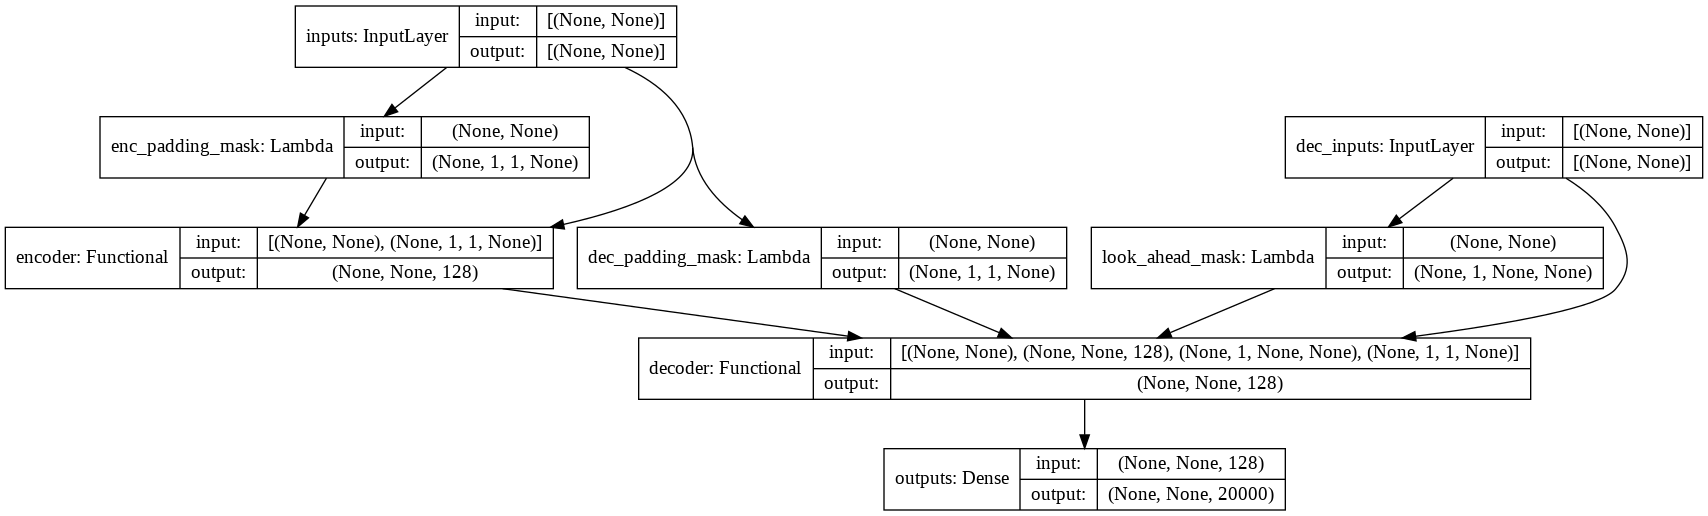

In [ ]:
small_transformer= transformer(
    kor_dict_size = kor_dict_size,
    eng_dict_size = eng_dict_size,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def get_config(self):
    config = {
    'd_model': self.d_model,
    'warmup_steps': self.warmup_steps,

    }
    return config

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)
  
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

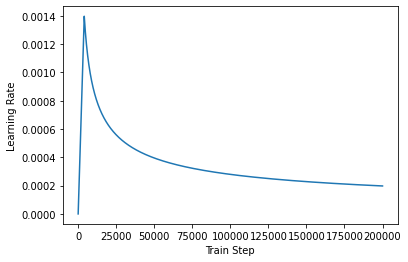

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters / 최적화 진행시켜보기
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    kor_dict_size=kor_dict_size,
    eng_dict_size=eng_dict_size,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 17557, 256)
(1, 20000, 256)


In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
checkpoint_filepath = "./drive/My Drive/comic_trans_project/checkpoints/transformer_komoran.hdf5"
save_best = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch', options=None)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

In [ ]:
!wandb login eb738ba304b560fc8b41bf28ba686d71a2b3d5d4
wandb_project = "transformer_komoran"
wandb_group = "transformer_komoran"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project=wandb_project) 
wandbCallback = WandbCallback()
EPOCHS = 30

history = model.fit(train_data, epochs=EPOCHS, validation_data= test_data, callbacks=[save_best, early_stopping, wandbCallback])

Epoch 1/30
852/852 [==============================] - 176s 191ms/step - loss: 0.9909 - accuracy: 0.0317 - val_loss: 0.7163 - val_accuracy: 0.0462

Epoch 00001: val_loss improved from inf to 0.71633, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_komoran.hdf5


wandb: ERROR Can't save model, h5py returned error: ('Not JSON Serializable:', <tf.Tensor: shape=(), dtype=float32, numpy=256.0>)


Epoch 2/30
852/852 [==============================] - 158s 185ms/step - loss: 0.6745 - accuracy: 0.0502 - val_loss: 0.5994 - val_accuracy: 0.0564

Epoch 00002: val_loss improved from 0.71633 to 0.59937, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_komoran.hdf5
Epoch 3/30
255/852 [=======>......................] - ETA: 1:27 - loss: 0.6069 - accuracy: 0.0547

wandb: 500 encountered ({"error":"Error 1040: Too many connections"}), retrying request
wandb: Network error resolved after 0:00:37.453271, resuming normal operation.


852/852 [==============================] - 156s 183ms/step - loss: 0.5885 - accuracy: 0.0582 - val_loss: 0.5118 - val_accuracy: 0.0657

Epoch 00003: val_loss improved from 0.59937 to 0.51179, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_komoran.hdf5
Epoch 4/30
852/852 [==============================] - 153s 180ms/step - loss: 0.5242 - accuracy: 0.0651 - val_loss: 0.4480 - val_accuracy: 0.0727

Epoch 00004: val_loss improved from 0.51179 to 0.44800, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_komoran.hdf5


wandb: 500 encountered ({"error":"Error 1040: Too many connections"}), retrying request
wandb: Network error resolved after 0:05:04.932343, resuming normal operation.


Epoch 5/30
852/852 [==============================] - 151s 178ms/step - loss: 0.4768 - accuracy: 0.0702 - val_loss: 0.3930 - val_accuracy: 0.0795

Epoch 00005: val_loss improved from 0.44800 to 0.39297, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_komoran.hdf5
Epoch 6/30
852/852 [==============================] - 151s 178ms/step - loss: 0.4287 - accuracy: 0.0757 - val_loss: 0.3375 - val_accuracy: 0.0870

Epoch 00006: val_loss improved from 0.39297 to 0.33752, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_komoran.hdf5
Epoch 7/30
852/852 [==============================] - 154s 180ms/step - loss: 0.3825 - accuracy: 0.0815 - val_loss: 0.2920 - val_accuracy: 0.0940

Epoch 00007: val_loss improved from 0.33752 to 0.29196, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_komoran.hdf5
Epoch 8/30
852/852 [==============================] - 154s 180ms/step - loss: 0.3439 - accuracy: 0.0867 - val_loss: 0.253

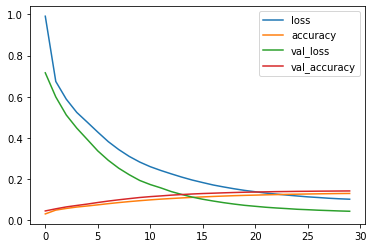

In [ ]:
pd.DataFrame(history.history).plot()
plt.savefig('transformer_komoran_score.png')
plt.show()

# Load Model & Prediction

(1, 17557, 256)
(1, 20000, 256)


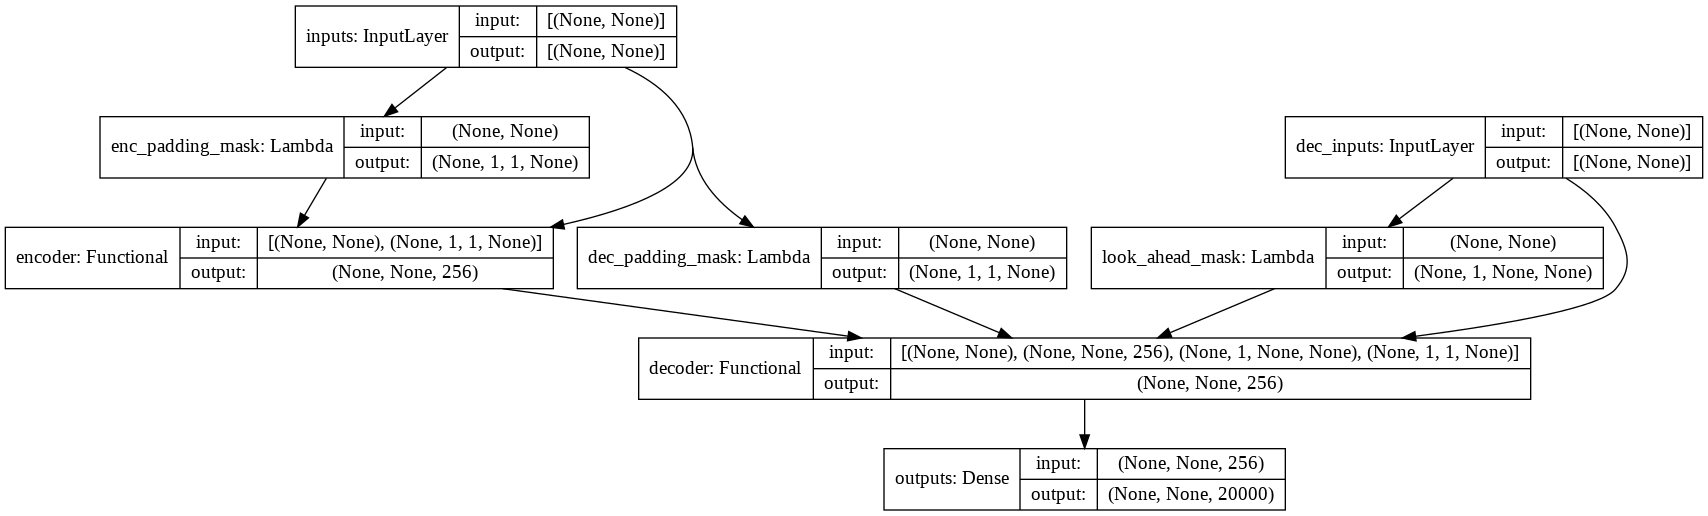

In [ ]:
model = transformer(
    kor_dict_size=kor_dict_size,
    eng_dict_size=eng_dict_size,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.load_weights('./drive/My Drive/comic_trans_project/checkpoints/transformer_komoran.hdf5')
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
tf.keras.utils.plot_model(
    model, to_file='transformer_komoran.png', show_shapes=True)

In [ ]:
def evaluate(sentence):
  sentence, _ = vectorize_data(sentence, kor_dict, True)
  sentence = tf.expand_dims(sentence[0], axis=0)
  output = tf.expand_dims([eng_dict['<S>']], 0)
  decoded_tokens = []
  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, eng_dict['<EOS>']):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [ ]:
def predict(sentence):
  prediction = evaluate(sentence)
  final = []
  for i in prediction :
    if i < eng_dict_size and i != 3:
      final.append(output_dict[i.numpy()])

  return ' '.join(final)

In [ ]:
def compare_prediction(data, limit=20):
    # evaluate a model
    compare_df = pd.DataFrame(columns=['Korean','English','Translated'])
    for i, sentence in enumerate(data['Korean']): # translate encoded source text
        compare_df = compare_df.append(pd.DataFrame([[sentence, data['English'][i], predict([sentence])]], columns=['Korean','English','Translated']), ignore_index=True)
        if i >= limit: # Display some of the result
           break
    return compare_df
# test on some training sequences
print('### Result on the Training Set ###')
compare_komoran_train = compare_prediction(train)
compare_komoran_train.to_csv('compare_komoran_train', mode='w')

### Result on the Training Set ###


In [ ]:
# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_komoran_test = compare_prediction(test)
compare_komoran_test.to_csv('compare_komoran_test', mode='w')



### Result on the Test Set ###


# BLEU Score

In [ ]:
train_shuffle = train.iloc[indices_train, :]
indices_test = np.arange(test.shape[0])
np.random.shuffle(indices_test)
test_shuffle = test.iloc[indices_test, :]
train_shuffle.reset_index(drop=True, inplace=True)
test_shuffle.reset_index(drop=True, inplace=True)

In [ ]:
# It takes long to compute the BLEU Score

def bleu_score(data):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, sentence in enumerate(data['Korean'][:1000]):
        # translate encoded source text
        translation = predict([sentence])
        target= data['English'][i]
        actual.append([target.split()])
        predicted.append(translation.split())
    bleu_dic = {}
    bleu_dic['1-grams'] = bleu.corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = bleu.corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = bleu.corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = bleu.corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu_dic

# Compute the BLEU Score
bleu_train = bleu_score(train_shuffle)
bleu_test = bleu_score(test_shuffle)

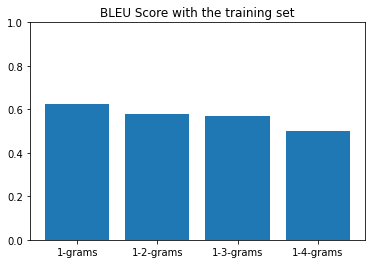

In [ ]:
plt.bar(x = bleu_train.keys(), height = bleu_train.values())
plt.title("BLEU Score with the training set")
plt.ylim((0,1))
plt.savefig('bleu_train_komoran.png', dpi=300)
plt.show()

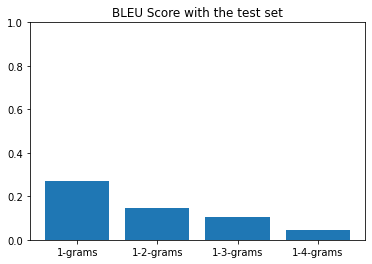

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.savefig('bleu_test_komoran.png', dpi=300)
plt.show()

In [ ]:
print(bleu_train)
print(bleu_test)

{'1-grams': 0.6247051254557152, '1-2-grams': 0.5764639741606478, '1-3-grams': 0.5700995328977707, '1-4-grams': 0.4984272167262564}
{'1-grams': 0.27069192584337964, '1-2-grams': 0.14447057861956702, '1-3-grams': 0.1031333660874258, '1-4-grams': 0.046596105748538376}


# Subword

In [ ]:
def make_morph(data, korean=False) :

  total_morph=[]
  for sentence in data:
      morph_sentence= []
      count = 0
      
      if korean :
        token_morohs = mecab(sentence)
      else : 
        token_morohs = nltk.word_tokenize(sentence)

      for token_moroh in token_morohs:
          token_moroh_save = token_moroh
          if count > 0:
              token_moroh_save = "##" + token_moroh_save  # 앞에 ##를 부친다
              morph_sentence.append(token_moroh_save)
          else:
              morph_sentence.append(token_moroh_save)
              count += 1
      total_morph.append(morph_sentence)

  return total_morph
                        
korean_morph = make_morph(kor2eng['Korean'], True)
english_morph = make_morph(kor2eng['English'])
with open('token/korean_morph.txt', 'w', encoding='utf-8') as f:
  for i in korean_morph :
    f.write(' '.join(i)+'\n')
with open('token/english_morph.txt', 'w', encoding='utf-8') as f:
  for i in english_morph :
    f.write(' '.join(i)+'\n')

In [ ]:
# define special tokens
user_defined_symbols = ['[BOS]','[EOS]','[UNK0]','[UNK1]','[UNK2]','[UNK3]','[UNK4]','[UNK5]','[UNK6]','[UNK7]','[UNK8]','[UNK9]']
unused_token_num = 200
unused_list = ['[unused{}]'.format(n) for n in range(unused_token_num)]
user_defined_symbols = user_defined_symbols + unused_list

print(user_defined_symbols)

['[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]', '[unused34]', '[unused35]', '[unused36]', '[unused37]', '[unused38]', '[unused39]', '[unused40]', '[unused41]', '[unused42]', '[unused43]', '[unused44]', '[unused45]', '[unused46]', '[unused47]', '[unused48]', '[unused49]', '[unused50]', '[unused51]', '[unused52]', '[unused53]', '[unused54]', '[unused55]', '[unused56]', '[unused57]', '[unused58]', '[unused59]', '[unused60]', '[unused61]', '[unused62]', '[unused6

In [ ]:
korean_tokenizer = BertWordPieceTokenizer(strip_accents=False, lowercase=False)
corpus_file   = ['token/korean_morph.txt']  # data path
vocab_size    = 32000
limit_alphabet= 6000
output_path   = 'korean_%d'%(vocab_size)
min_frequency = 5

# Then train it!
korean_tokenizer.train(files=corpus_file,
               vocab_size=vocab_size,
               min_frequency=min_frequency,  # 단어의 최소 발생 빈도, 5
               limit_alphabet=limit_alphabet,  # ByteLevelBPETokenizer 학습시엔 주석처리 필요
               show_progress=True)
print('train complete')

sentence = '나는 오늘 아침밥을 먹었다.'
output = korean_tokenizer.encode(sentence)
print(sentence)
print('=>idx   : %s'%output.ids)
print('=>tokens: %s'%output.tokens)
print('=>offset: %s'%output.offsets)
print('=>decode: %s\n'%korean_tokenizer.decode(output.ids))

# save tokenizer
hf_model_path_kr='./drive/My Drive/comic_trans_project/token/korean_tokenizer_model'
if not os.path.isdir(hf_model_path_kr):
    os.mkdir(hf_model_path_kr)
korean_tokenizer.save_model(hf_model_path_kr)  # vocab.txt 파일 한개가 만들어진다

train complete
나는 오늘 아침밥을 먹었다.
=>idx   : [272, 1864, 2816, 6663, 2158, 616, 1819, 1655, 8]
=>tokens: ['나', '##는', '오늘', '아침밥', '##을', '먹', '##었', '##다', '.']
=>offset: [(0, 1), (1, 2), (3, 5), (6, 9), (9, 10), (11, 12), (12, 13), (13, 14), (14, 15)]
=>decode: 나는 오늘 아침밥을 먹었다.



['./drive/My Drive/comic_trans_project/token/korean_tokenizer_model/vocab.txt']

In [ ]:
english_tokenizer = BertWordPieceTokenizer()
corpus_file   = ['token/english_morph.txt']  # data path
vocab_size    = 32000
limit_alphabet= 6000
output_path   = 'english_%d'%(vocab_size)
min_frequency = 5

# Then train it!
english_tokenizer.train(files=corpus_file,
               vocab_size=vocab_size,
               min_frequency=min_frequency,  # 단어의 최소 발생 빈도, 5
               limit_alphabet=limit_alphabet,  # ByteLevelBPETokenizer 학습시엔 주석처리 필요
               show_progress=True)
print('train complete')

sentence = 'I want to go my hometown'
output = english_tokenizer.encode(sentence)
print(sentence)
print('=>idx   : %s'%output.ids)
print('=>tokens: %s'%output.tokens)
print('=>offset: %s'%output.offsets)
print('=>decode: %s\n'%english_tokenizer.decode(output.ids))

# save tokenizer
hf_model_path_en='./drive/My Drive/comic_trans_project/token/english_tokenizer_model'
if not os.path.isdir(hf_model_path_en):
    os.mkdir(hf_model_path_en)
english_tokenizer.save_model(hf_model_path_en)  # vocab.txt 파일 한개가 만들어진다

train complete
I want to go my hometown
=>idx   : [28, 518, 142, 254, 233, 642, 1593, 513]
=>tokens: ['i', 'want', 'to', 'go', 'my', 'home', '##to', '##wn']
=>offset: [(0, 1), (2, 6), (7, 9), (10, 12), (13, 15), (16, 20), (20, 22), (22, 24)]
=>decode: i want to go my hometown



['./drive/My Drive/comic_trans_project/token/english_tokenizer_model/vocab.txt']

In [ ]:
tokenizer_kr = BertTokenizerFast.from_pretrained(hf_model_path_kr,
                                                       strip_accents=False,  # Must be False if cased model
                                                       lowercase=False)  # 로드
tokenizer_en = BertTokenizerFast.from_pretrained(hf_model_path_en)
print('vocab size : %d' % tokenizer_kr.vocab_size)
print('vocab size : %d' % tokenizer_en.vocab_size)

tokenized_input= tokenizer_kr("나는 오늘 아침밥을 먹었다.", return_tensors="tf")
tokenized_output= tokenizer_en("나는 오늘 아침밥을 먹었다.", return_tensors="tf")

vocab size : 10776
vocab size : 11014


In [ ]:
tokenizer_kr.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [ ]:
# tokenizer에 special token 추가
special_tokens_dict = {'additional_special_tokens': user_defined_symbols}
tokenizer_kr.add_special_tokens(special_tokens_dict)
tokenizer_en.add_special_tokens(special_tokens_dict)

212

In [ ]:
# save tokenizer model with special tokens
tokenizer_kr.save_pretrained(hf_model_path_kr+'_special')
tokenizer_en.save_pretrained(hf_model_path_en+'_special')

('./drive/My Drive/comic_trans_project/token/english_tokenizer_model_special/tokenizer_config.json',
 './drive/My Drive/comic_trans_project/token/english_tokenizer_model_special/special_tokens_map.json',
 './drive/My Drive/comic_trans_project/token/english_tokenizer_model_special/vocab.txt',
 './drive/My Drive/comic_trans_project/token/english_tokenizer_model_special/added_tokens.json')

In [ ]:
hf_model_path_kr='./drive/My Drive/comic_trans_project/token/korean_tokenizer_model'
hf_model_path_en='./drive/My Drive/comic_trans_project/token/english_tokenizer_model'
tokenizer_kr = BertTokenizerFast.from_pretrained(hf_model_path_kr+'_special')
tokenizer_en = BertTokenizerFast.from_pretrained(hf_model_path_en+'_special')

In [ ]:
train_size = int(len(kor2eng['Korean'])*0.9)
train_size
train = kor2eng[:train_size]
test = kor2eng[train_size:]
test.reset_index(drop=True,inplace=True)
train.shape, test.shape

((54501, 2), (6056, 2))

In [ ]:
MAX_LENGTH = 70

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = tokenizer_kr.encode(sentence1)
    sentence2 = tokenizer_en.encode(sentence2)

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [ ]:
x_train, y_train = tokenize_and_filter(train['Korean'], train['English'])

In [ ]:
x_test, y_test = tokenize_and_filter(test['Korean'], test['English'])

In [ ]:
x_train.shape, y_train.shape

((54501, 70), (54501, 70))

In [ ]:
x_test.shape, y_test.shape

((6056, 70), (6056, 70))

In [ ]:
def make_dataset(x_data, y_data):

  # 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
  # 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
  BATCH_SIZE = 64
  BUFFER_SIZE = 20000

  # 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
  dataset = tf.data.Dataset.from_tensor_slices((
      {
          'inputs': x_train,
          'dec_inputs': y_train[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
      },
      {
          'outputs': y_train[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
      },
  ))

  dataset = dataset.cache()
  dataset = dataset.shuffle(BUFFER_SIZE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return dataset

In [ ]:
train_data = make_dataset(x_train, y_train)
test_data = make_dataset(x_test, y_test)

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_config(self):
    cfg = super().get_config()
    return cfg 
    
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  def get_config(self):
    cfg = super().get_config()
    return cfg 
    
  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

def encoder(kr_vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(tokenizer_kr.vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(tokenizer_kr.vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

def decoder(en_vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(tokenizer_en.vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(tokenizer_en.vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

def transformer(kr_vocab_size, en_vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(kr_vocab_size=tokenizer_kr.vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(en_vocab_size=tokenizer_en.vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=tokenizer_en.vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def get_config(self):
    config = {
    'd_model': self.d_model,
    'warmup_steps': self.warmup_steps,

    }
    return config

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)
  
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters / 최적화 진행시켜보기
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    kr_vocab_size=tokenizer_kr.vocab_size,
    en_vocab_size=tokenizer_en.vocab_size,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 10776, 256)
(1, 11014, 256)


In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
checkpoint_filepath = "./drive/My Drive/comic_trans_project/checkpoints/transformer_subword.hdf5"
save_best = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch', options=None)
early_stopping = EarlyStopping(monitor='loss', mode='auto', verbose=1, patience=10)

In [ ]:
!wandb login eb738ba304b560fc8b41bf28ba686d71a2b3d5d4
wandb_project = "transformer_subword"
wandb_group = "transformer_subword"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project=wandb_project) 
wandbCallback = WandbCallback()
EPOCHS = 30
history = model.fit(train_data, epochs=EPOCHS, validation_data=test_data, callbacks=[save_best, early_stopping, wandbCallback])

wandb: Currently logged in as: mugan (use `wandb login --relogin` to force relogin)


Epoch 1/30
852/852 [==============================] - 116s 122ms/step - loss: 1.0298 - accuracy: 0.0322 - val_loss: 0.7821 - val_accuracy: 0.0472

Epoch 00001: loss improved from inf to 1.02983, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_subword.hdf5


wandb: ERROR Can't save model, h5py returned error: ('Not JSON Serializable:', <tf.Tensor: shape=(), dtype=float32, numpy=256.0>)


Epoch 2/30
852/852 [==============================] - 99s 117ms/step - loss: 0.7353 - accuracy: 0.0512 - val_loss: 0.6574 - val_accuracy: 0.0577

Epoch 00002: loss improved from 1.02983 to 0.73529, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_subword.hdf5
Epoch 3/30
852/852 [==============================] - 99s 117ms/step - loss: 0.6409 - accuracy: 0.0597 - val_loss: 0.5580 - val_accuracy: 0.0676

Epoch 00003: loss improved from 0.73529 to 0.64095, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_subword.hdf5
Epoch 4/30
852/852 [==============================] - 100s 117ms/step - loss: 0.5674 - accuracy: 0.0668 - val_loss: 0.4807 - val_accuracy: 0.0752

Epoch 00004: loss improved from 0.64095 to 0.56741, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_subword.hdf5
Epoch 5/30
852/852 [==============================] - 100s 118ms/step - loss: 0.5109 - accuracy: 0.0722 - val_loss: 0.4147 - val_accura

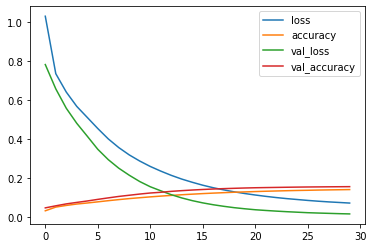

In [ ]:
pd.DataFrame(history.history).plot()
plt.show()

(1, 10776, 256)
(1, 11014, 256)


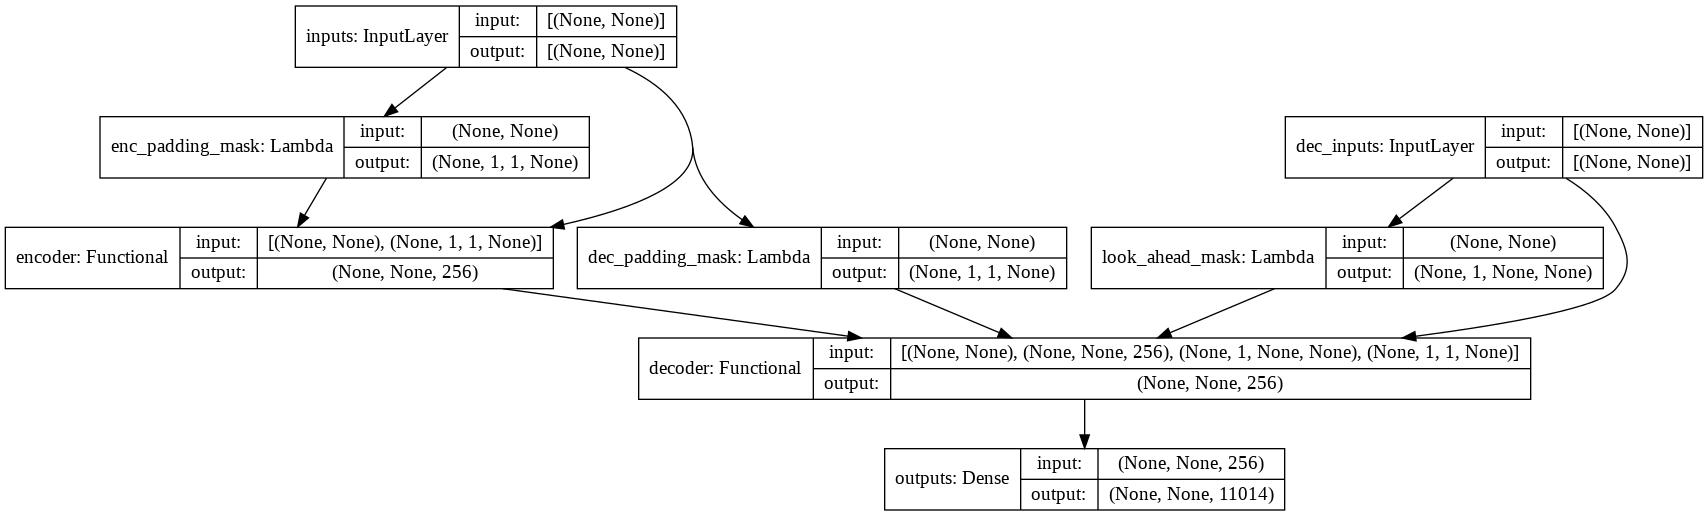

In [ ]:
model = transformer(
    kr_vocab_size=tokenizer_kr.vocab_size,
    en_vocab_size=tokenizer_en.vocab_size,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.load_weights('./drive/My Drive/comic_trans_project/checkpoints/transformer_subword.hdf5')
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
tf.keras.utils.plot_model(
    model, to_file='transformer_subword.png', show_shapes=True)

In [ ]:
def evaluate(sentence):

  sentence = tf.expand_dims(tokenizer_kr.encode(sentence), axis=0)
  output = tf.expand_dims([tokenizer_kr.cls_token_id], 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, tokenizer_en.sep_token_id):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [ ]:
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer_en.decode(
      [i for i in prediction if i < tokenizer_en.vocab_size and i != 2])

  return predicted_sentence

In [ ]:
def compare_prediction(data, limit=20):
    # evaluate a model
    compare_df = pd.DataFrame(columns=['Korean','English','Translated'])
    for i, sentence in enumerate(data['Korean']): # translate encoded source text
        compare_df = compare_df.append(pd.DataFrame([[sentence, data['English'][i], predict(sentence)]], columns=['Korean','English','Translated']), ignore_index=True)
        if i >= limit: # Display some of the result
           break
    return compare_df
# test on some training sequences
print('### Result on the Training Set ###')
compare_subword_train = compare_prediction(train)
compare_subword_train.to_csv('compare_subword_train', mode='w')

### Result on the Training Set ###


In [ ]:
# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_subword_test = compare_prediction(test)
compare_subword_test.to_csv('compare_subword_test', mode='w')



### Result on the Test Set ###


In [ ]:
indices_train = np.arange(train.shape[0])
np.random.shuffle(indices_train)
train_shuffle = train.iloc[indices_train, :]
indices_test = np.arange(test.shape[0])
np.random.shuffle(indices_test)
test_shuffle = test.iloc[indices_test, :]
train_shuffle.reset_index(drop=True, inplace=True)
test_shuffle.reset_index(drop=True, inplace=True)

In [ ]:
# It takes long to compute the BLEU Score

def bleu_score(data):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, sentence in enumerate(data['Korean'][:1000]):
        # translate encoded source text
        translation = predict(sentence)
        target= data['English'][i]
        actual.append([target.split()])
        predicted.append(translation.split())
    bleu_dic = {}
    bleu_dic['1-grams'] = bleu.corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = bleu.corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = bleu.corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = bleu.corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu_dic

# Compute the BLEU Score
bleu_train = bleu_score(train_shuffle)
bleu_test = bleu_score(test_shuffle)

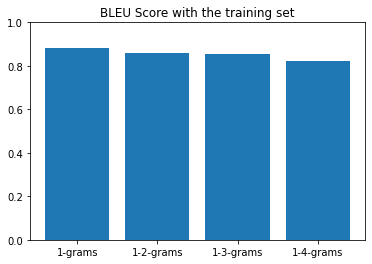

In [ ]:
plt.bar(x = bleu_train.keys(), height = bleu_train.values())
plt.title("BLEU Score with the training set")
plt.ylim((0,1))
plt.savefig('bleu_train_subword.png', dpi=300)
plt.show()

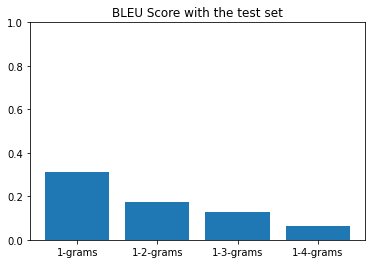

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.savefig('bleu_test_subword.png', dpi=300)
plt.show()

In [ ]:
print(bleu_train)
print(bleu_test)

{'1-grams': 0.8832836058812289, '1-2-grams': 0.8599436253126335, '1-3-grams': 0.8549806294361234, '1-4-grams': 0.8236319179653637}
{'1-grams': 0.3138122801044149, '1-2-grams': 0.17564446147232352, '1-3-grams': 0.1295513429329032, '1-4-grams': 0.06292363551080707}


# Mecab

In [ ]:
# 데이터 전처리 

class Kor2EngData:
    def __init__(self, data_dir):
        self.files = os.listdir(data_dir)
        self.files = [os.path.join(data_dir, f) for f in self.files]
        self.eng = []
        self.kor = []
        self.datas = []
        
    def data_processing(self):
        self.make_data_to_list()
        self.split_eng_kor()
        
        return self.eng, self.kor
        
    def make_data_to_list(self):
        for file in self.files:
            try:
                with open(file, 'r', encoding='cp949') as f:
                    all_data = f.readlines()
                    
                    for data in all_data:
                        data = data.replace('\n', '')
                        data = data.replace('#', '')
                                       
                        if len(data) != 0:
                            self.datas.append(data)
            except:
                pass
        
    def split_eng_kor(self):        
        for i in range(len(self.datas) - 3):
            if self.datas[i][0] == '[':
                if self.datas[i + 3][0] == '[': 
                    self.eng.append(clean_text(self.datas[i + 1]))
                    self.kor.append(clean_text(self.datas[i + 2]))
                    

    def make_dictionary(self, data, Korean=False):
        words = []
        for sentence in data:
            if not Korean:
                tokens = nltk.word_tokenize(sentence)
                            
            else:
                tokens = mecab(sentence)
              # tokens = mecab(sentence)
            for word in tokens:
                if has_number(word):
                    tokens.remove(word)
                        
            words.extend(tokens)

        words = collections.Counter(words)

        dictionary = {}
        dictionary['<PAD>'] = 0
        dictionary['<UNK>'] = 1
        dictionary['<EOS>'] = 2
        dictionary['<S>'] = 3
        idx = 4
        for word in words.most_common():
            if len(word[0]) > 0:
                dictionary[word[0]] = idx
                idx += 1
            
            if idx >= 20000: break;

        return dictionary
    
def clean_text(text):
    return re.sub('[\{\}\[\]\/,;:|\)*~`^\-_+<>@\#$%&\\\=\(\"“”◀▶【©】☎]', '', text.lower())

def has_number(word):
    return any(char.isdigit() for char in word)

In [ ]:
MAX_LENGTH = 61

kor2eng = Kor2EngData(data_directory)
eng, kor = kor2eng.data_processing()

eng_dict = kor2eng.make_dictionary(eng)
kor_dict = kor2eng.make_dictionary(kor, True)

output_dict = {y:x for x,y in eng_dict.items()}
input_dict = {y:x for x,y in kor_dict.items()}

eng_dict_size = len(eng_dict)
kor_dict_size = len(kor_dict)

eng_df = pd.DataFrame(eng, columns=['English'])
kor_df = pd.DataFrame(kor, columns=['Korean'])
kor2eng = pd.concat([eng_df, kor_df], axis=1)

for i, eng in enumerate(kor2eng['English']):
    if len(eng) > MAX_LENGTH:
        kor2eng.drop(kor2eng.index[i])
for i, kor in enumerate(kor2eng['Korean']):
    if len(kor) > MAX_LENGTH:
        kor2eng.drop(kor2eng.index[i])

print("English Dictionary Size: ", eng_dict_size)
print("Korean Dictionary Size: ", kor_dict_size)


English Dictionary Size:  20000
Korean Dictionary Size:  20000


In [ ]:
train_size = int(len(kor2eng['Korean'])*0.9)
train_size
train = kor2eng[:train_size]
test = kor2eng[train_size:]
test.reset_index(drop=True,inplace=True)
train.shape, test.shape

((54501, 2), (6056, 2))

In [ ]:
# 벡터화

def vectorize_data(data, dictionary, Korean=False):
    max_len = 60
    vec_sentence = []

    for sentence in data:
        temp = []
        
        temp.append(dictionary['<S>'])
        
        if not Korean:
            for word in nltk.word_tokenize(sentence):
                if len(word) > 0:
                    if word in dictionary:
                        temp.append(dictionary[word])
                    else:
                        temp.append(dictionary['<UNK>'])
        else:
            
            for word in mecab(sentence):
                if len(word) > 0:
                    if word in dictionary:
                        temp.append(dictionary[word])
                    else:
                        temp.append(dictionary['<UNK>'])
            
        temp.append(dictionary['<EOS>'])
        
        if max_len < len(temp):
            max_len = len(temp)

        vec_sentence.append(temp)
        
    return vec_sentence, max_len

def add_padding(vec_data, max_len):
    for sentence in vec_data:
        for i in range(len(sentence), max_len + 1):
            sentence.append(0)
    
    return np.array(vec_data)

kor_vec_train, kor_max_train = vectorize_data(train['Korean'], kor_dict, True)
kor_vec_test, kor_max_test = vectorize_data(test['Korean'], kor_dict, True)
eng_vec_train, eng_max_train = vectorize_data(train['English'], eng_dict)
eng_vec_test, eng_max_test = vectorize_data(test['English'], eng_dict)

x_train = add_padding(kor_vec_train, kor_max_train)
x_test = add_padding(kor_vec_test, kor_max_test)
y_train = add_padding(eng_vec_train, eng_max_train)
y_test = add_padding(eng_vec_test, eng_max_test)

In [ ]:
print('한국어 데이터의 크기(shape) :', x_train.shape)
print('영어 데이터의 크기(shape) :', y_train.shape)

한국어 데이터의 크기(shape) : (54501, 61)
영어 데이터의 크기(shape) : (54501, 61)


In [ ]:
def make_dataset(x_data, y_data):

  # 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
  # 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
  BATCH_SIZE = 64
  BUFFER_SIZE = 20000

  # 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
  dataset = tf.data.Dataset.from_tensor_slices((
      {
          'inputs': x_train,
          'dec_inputs': y_train[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
      },
      {
          'outputs': y_train[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
      },
  ))

  dataset = dataset.cache()
  dataset = dataset.shuffle(BUFFER_SIZE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return dataset

In [ ]:
train_data = make_dataset(x_train, y_train)
test_data = make_dataset(x_test, y_test)

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters / 최적화 진행시켜보기
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    kor_dict_size=kor_dict_size,
    eng_dict_size=eng_dict_size,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 20000, 256)
(1, 20000, 256)


In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
checkpoint_filepath = "./drive/My Drive/comic_trans_project/checkpoints/transformer_mecab.hdf5"
save_best = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch', options=None)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

In [ ]:
!wandb login eb738ba304b560fc8b41bf28ba686d71a2b3d5d4
wandb_project = "transformer_mecab"
wandb_group = "transformer_mecab"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project=wandb_project) 
wandbCallback = WandbCallback()
EPOCHS = 30

history = model.fit(train_data, epochs=EPOCHS, validation_data= test_data, callbacks=[save_best, early_stopping, wandbCallback])

epoch,29
loss,0.10303
accuracy,0.13101
val_loss,0.04459
val_accuracy,0.14314
_runtime,5227
_timestamp,1623255283
_step,29
best_val_loss,0.04459
best_epoch,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████████
val_loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇███████████
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


Epoch 1/30
852/852 [==============================] - 156s 177ms/step - loss: 1.1005 - accuracy: 0.0353 - val_loss: 0.7977 - val_accuracy: 0.0518

Epoch 00001: val_loss improved from inf to 0.79773, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_mecab.hdf5


wandb: ERROR Can't save model, h5py returned error: ('Not JSON Serializable:', <tf.Tensor: shape=(), dtype=float32, numpy=256.0>)


Epoch 2/30
852/852 [==============================] - 151s 177ms/step - loss: 0.7538 - accuracy: 0.0559 - val_loss: 0.6743 - val_accuracy: 0.0625

Epoch 00002: val_loss improved from 0.79773 to 0.67434, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_mecab.hdf5
Epoch 3/30
852/852 [==============================] - 151s 177ms/step - loss: 0.6596 - accuracy: 0.0650 - val_loss: 0.5758 - val_accuracy: 0.0730

Epoch 00003: val_loss improved from 0.67434 to 0.57576, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_mecab.hdf5
Epoch 4/30
852/852 [==============================] - 152s 178ms/step - loss: 0.5866 - accuracy: 0.0726 - val_loss: 0.5001 - val_accuracy: 0.0816

Epoch 00004: val_loss improved from 0.57576 to 0.50014, saving model to ./drive/My Drive/comic_trans_project/checkpoints/transformer_mecab.hdf5
Epoch 5/30
852/852 [==============================] - 153s 179ms/step - loss: 0.5329 - accuracy: 0.0782 - val_loss: 0.4411 - va

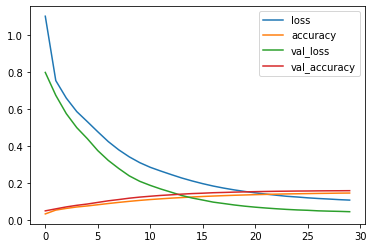

In [ ]:
pd.DataFrame(history.history).plot()
plt.savefig('transformer_mecab_score.png')
plt.show()

(1, 20000, 256)
(1, 20000, 256)


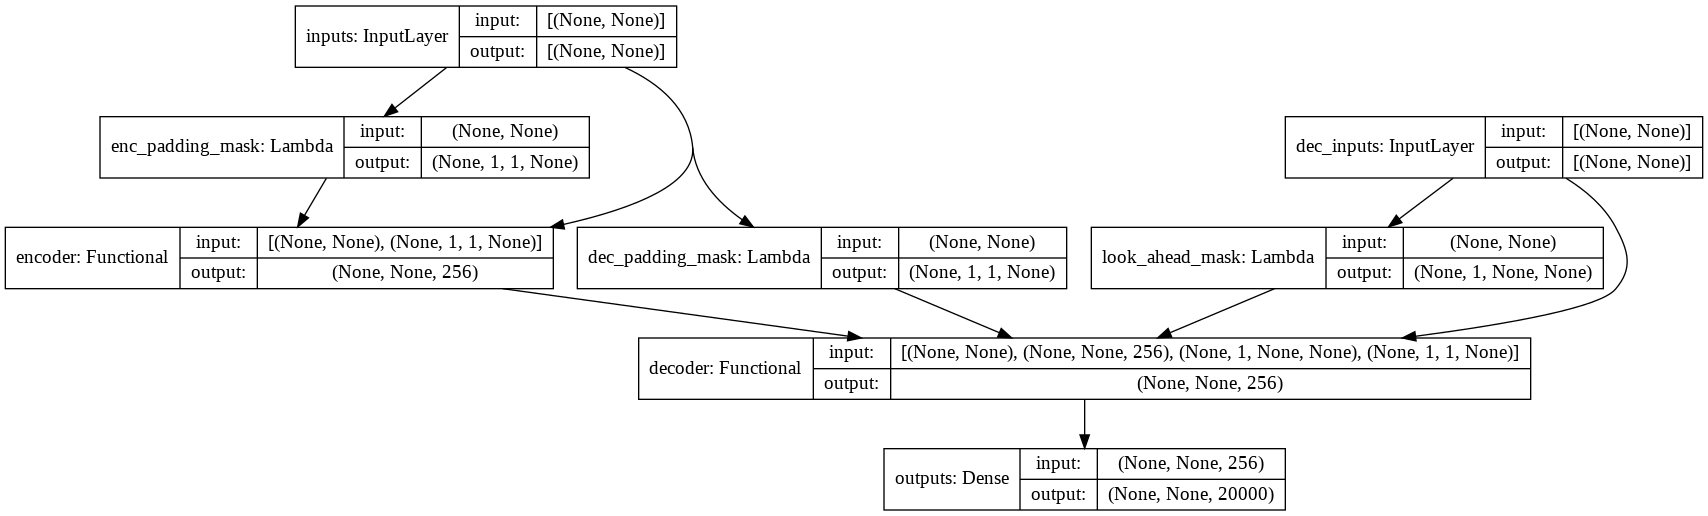

In [ ]:
model = transformer(
    kor_dict_size=kor_dict_size,
    eng_dict_size=eng_dict_size,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.load_weights('./drive/My Drive/comic_trans_project/checkpoints/transformer_mecab.hdf5')
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
tf.keras.utils.plot_model(
    model, to_file='transformer_mecab.png', show_shapes=True)

In [ ]:
def evaluate(sentence):
  sentence, _ = vectorize_data(sentence, kor_dict, True)
  sentence = tf.expand_dims(sentence[0], axis=0)
  output = tf.expand_dims([eng_dict['<S>']], 0)
  decoded_tokens = []
  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, eng_dict['<EOS>']):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [ ]:
def predict(sentence):
  prediction = evaluate(sentence)
  final = []
  for i in prediction :
    if i < eng_dict_size and i != 3:
      final.append(output_dict[i.numpy()])

  return ' '.join(final)

In [ ]:
def compare_prediction(data, limit=20):
    # evaluate a model
    compare_df = pd.DataFrame(columns=['Korean','English','Translated'])
    for i, sentence in enumerate(data['Korean']): # translate encoded source text
        compare_df = compare_df.append(pd.DataFrame([[sentence, data['English'][i], predict([sentence])]], columns=['Korean','English','Translated']), ignore_index=True)
        if i >= limit: # Display some of the result
           break
    return compare_df
# test on some training sequences
print('### Result on the Training Set ###')
compare_mecab_train = compare_prediction(train)
compare_mecab_train.to_csv('compare_mecab_train', mode='w')

### Result on the Training Set ###


In [ ]:
compare_mecab_test = compare_prediction(test)
compare_mecab_test.to_csv('compare_mecab_test', mode='w')

In [ ]:
train_shuffle = train.iloc[indices_train, :]
indices_test = np.arange(test.shape[0])
np.random.shuffle(indices_test)
test_shuffle = test.iloc[indices_test, :]
train_shuffle.reset_index(drop=True, inplace=True)
test_shuffle.reset_index(drop=True, inplace=True)

In [ ]:
# It takes long to compute the BLEU Score

def bleu_score(data):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, sentence in enumerate(data['Korean'][:1000]):
        # translate encoded source text
        translation = predict([sentence])
        target= data['English'][i]
        actual.append([target.split()])
        predicted.append(translation.split())
    bleu_dic = {}
    bleu_dic['1-grams'] = bleu.corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = bleu.corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = bleu.corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = bleu.corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu_dic

# Compute the BLEU Score
bleu_train = bleu_score(train_shuffle)
bleu_test = bleu_score(test_shuffle)

wandb: Network error resolved after 0:43:40.299039, resuming normal operation.


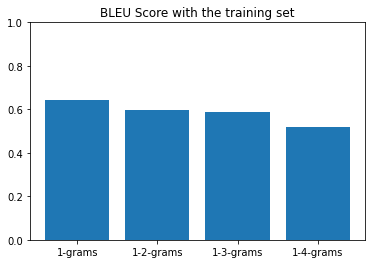

In [ ]:
plt.bar(x = bleu_train.keys(), height = bleu_train.values())
plt.title("BLEU Score with the training set")
plt.ylim((0,1))
plt.savefig('bleu_train_mecab.png', dpi=300)
plt.show()

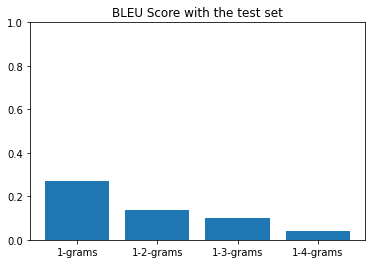

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.savefig('bleu_test_mecab.png', dpi=300)
plt.show()

In [ ]:
print(bleu_train)
print(bleu_test)

{'1-grams': 0.6426949280847842, '1-2-grams': 0.595892095383663, '1-3-grams': 0.589645933337336, '1-4-grams': 0.5194262178651233}
{'1-grams': 0.2699367734040383, '1-2-grams': 0.13906944057361728, '1-3-grams': 0.09796896000501099, '1-4-grams': 0.04159049083475319}


# CV

In [ ]:
MAX_LENGTH = 70

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = tokenizer_kr.encode(sentence1)
    sentence2 = tokenizer_en.encode(sentence2)

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [ ]:
x_train, y_train = tokenize_and_filter(kor2eng['Korean'], kor2eng['English'])

In [ ]:
def make_dataset(x_train, y_train):

  # 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
  # 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
  BATCH_SIZE = 64
  BUFFER_SIZE = 20000

  # 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
  dataset = tf.data.Dataset.from_tensor_slices((
      {
          'inputs': x_train,
          'dec_inputs': y_train[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
      },
      {
          'outputs': y_train[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
      },
  ))

  dataset = dataset.cache()
  dataset = dataset.shuffle(BUFFER_SIZE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return dataset

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters / 최적화 진행시켜보기
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    kr_vocab_size=tokenizer_kr.vocab_size,
    en_vocab_size=tokenizer_en.vocab_size,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train, test in kfold.split(x_train, y_train):

  save_best = keras.callbacks.ModelCheckpoint(filepath=f'./drive/My Drive/comic_trans_project/checkpoints/subword_fold-%i.h5'%fold_no, monitor='loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch', options=None)
  train_dataset = make_dataset(x_train[train], y_train[train])
  test_dataset = make_dataset(x_train[test], y_train[test])
  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(train_dataset, epochs=15, callbacks=[save_best])

  # Generate generalization metrics
  scores = model.evaluate(test_dataset, verbose=1)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/15
947/947 [==============================] - 137s 132ms/step - loss: 1.0148 - accuracy: 0.0332

Epoch 00001: loss improved from inf to 1.01480, saving model to ./drive/My Drive/comic_trans_project/checkpoints/subword_fold-1.h5
Epoch 2/15
947/947 [==============================] - 122s 129ms/step - loss: 0.7209 - accuracy: 0.0534

Epoch 00002: loss improved from 1.01480 to 0.72090, saving model to ./drive/My Drive/comic_trans_project/checkpoints/subword_fold-1.h5
Epoch 3/15
947/947 [==============================] - 122s 128ms/step - loss: 0.6225 - accuracy: 0.0623

Epoch 00003: loss improved from 0.72090 to 0.62251, saving model to ./drive/My Drive/comic_trans_project/checkpoints/subword_fold-1.h5
Epoch 4/15
947/947 [==============================] - 123s 129ms/step - loss: 0.5511 - accuracy: 0.0692

Epoch 00004: loss improved from 0.62251 to 0.55110, saving model to ./drive/My Dri

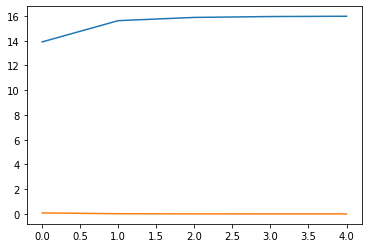

In [ ]:
plt.plot(acc_per_fold)
plt.plot(loss_per_fold)
plt.savefig('cv.png')
plt.show();

In [ ]:
# Hyper-parameters 
# NUM_LAYERS = 2
# NUM_HEADS = 8
# DFF = 512
# DROPOUT = 0.1

# 논문
#num_layers = 6 , d_model = 512 , dff = 2048 
tf.keras.backend.clear_session()

def model_builder(hp) :

  hp_layers = hp.Int('layers', min_value = 2, max_value = 6, step = 2)
  hp_dmodel = hp.Choice('dmodel', values =[128, 256, 512])
  hp_diff = hp.Choice('diff', values =[512, 1024, 2048])
  model = transformer(
      kr_vocab_size=tokenizer_kr.vocab_size,
      en_vocab_size=tokenizer_en.vocab_size,
      num_layers=hp_layers,
      dff=hp_diff,
      d_model=hp_dmodel,
      num_heads=NUM_HEADS,
      dropout=DROPOUT)
  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'loss', 
                     max_epochs = 10, # 일반적으로 10, 빠른 구현을 위해서 숫자를 줄였음.
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')   

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json
(1, 10776, 128)
(1, 11014, 128)
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
checkpoint_filepath = "./drive/My Drive/comic_trans_project/checkpoints/transformer_hyper.hdf5"
save_best = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch', options=None)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

In [ ]:
!wandb login eb738ba304b560fc8b41bf28ba686d71a2b3d5d4
wandb_project = "transformer_hyper"
wandb_group = "transformer_hyper"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project=wandb_project) 
wandbCallback = WandbCallback()

tuner.search(train_data, epochs = 3, validation_data=test_data, callbacks = [save_best,ClearTrainingOutput(), wandbCallback])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
하이퍼 파라미터 검색이 완료되었습니다. 
최적화된 LAYER 수는 {best_hps.get('layers')} 입니다.
최적의 D_MODEL은 {best_hps.get('dmodel')} 입니다.
최적의 DIFF는 {best_hps.get('diff')} 입니다.
""")

Trial 4 Complete [00h 51m 05s]
loss: 0.8586543798446655

Best loss So Far: 0.2762245833873749
Total elapsed time: 03h 00m 09s
INFO:tensorflow:Oracle triggered exit

하이퍼 파라미터 검색이 완료되었습니다. 
최적화된 LAYER 수는 2 입니다.
최적의 D_MODEL은 256 입니다.
최적의 DIFF는 2048 입니다.



In [ ]:
# 최적의 하이퍼 파라미터를 사용하여 모델을 구축하고 데이터에 대해 교육
model = tuner.hypermodel.build(best_hps)
model.summary()

(1, 10776, 256)
(1, 11014, 256)
Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    5388800     inputs[0][0]                     
                                                        

In [ ]:
!pip freeze>requirement.txt